# KoBERT finetuning

## 환경설정 - python
* python 3.7.0으로 맞춰주기
* gluonnlp에서 나는 에러코드 : `import gluonnlp as nlp AttributeError: module 'numpy' has no attribute 'bool'.`
    * numpy 버전 다운그레이드 : `!pip install numpy==1.23.1`
    * 참고 : [이슈 해결 블로그](https://sun-garret.tistory.com/42)

In [ ]:
!python --version

Python 3.10.12


In [ ]:
!wget https://www.python.org/ftp/python/3.7.0/Python-3.7.0.tgz
!tar xvfz Python-3.7.0.tgz
!Python-3.7.0/configure
!make
!sudo make install

In [ ]:
!python --version

Python 3.7.0


In [ ]:
!pip install 'git+https://github.com/SKTBrain/KoBERT.git#egg=kobert_tokenizer&subdirectory=kobert_hf'

  Cloning https://github.com/SKTBrain/KoBERT.git to /tmp/pip-install-swwfddmw/kobert-tokenizer_afcde0a6dbb24cae889b5053b8da606d
  Running command git clone --filter=blob:none --quiet https://github.com/SKTBrain/KoBERT.git /tmp/pip-install-swwfddmw/kobert-tokenizer_afcde0a6dbb24cae889b5053b8da606d
  Resolved https://github.com/SKTBrain/KoBERT.git to commit 5c46b1c68e4755b54879431bd302db621f4d2f47
  Preparing metadata (setup.py) ... done
  Created wheel for kobert_tokenizer: filename=kobert_tokenizer-0.1-py3-none-any.whl size=4633 sha256=cf524aa0fa174c703c160d37109423ba79b70d141d614718949e56ea622afadb
  Stored in directory: /tmp/pip-ephem-wheel-cache-3llzcwqx/wheels/e9/1a/3f/a864970e8a169c176befa3c4a1e07aa612f69195907a4045fe
Successfully built kobert_tokenizer


In [ ]:
!pip install mxnet
!pip install gluonnlp pandas tqdm
!pip install sentencepiece
!pip install transformers
!pip install torch

In [ ]:
import torch

print("Torch version:{}".format(torch.__version__))
print("cuda version: {}".format(torch.version.cuda))
print("cudnn version:{}".format(torch.backends.cudnn.version()))

Torch version:2.5.1+cu121
cuda version: 12.1
cudnn version:90100


In [ ]:
!pip install gluonnlp==0.8.0

In [ ]:
!pip install numpy==1.23.1

In [ ]:
import numpy as np

In [ ]:
!apt-get install -y fonts-nanum*
!rm -rf /root/.cache/matplotlib/* # 폰트 캐시 재설정

### import

In [ ]:
# 런타임 다시 시작 후 실행
# 한글 폰트 설정
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl

path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
font_name = mpl.font_manager.FontProperties(fname=path).get_name()
plt.rcParams['font.family'] = font_name

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import gluonnlp as nlp
import numpy as np
from tqdm import tqdm, tqdm_notebook

/usr/local/lib/python3.10/dist-packages/mxnet/optimizer/optimizer.py:163: UserWarning: WARNING: New optimizer gluonnlp.optimizer.lamb.LAMB is overriding existing optimizer mxnet.optimizer.optimizer.LAMB
  warnings.warn('WARNING: New optimizer %s.%s is overriding '


In [ ]:
import sklearn

In [ ]:
# ★ Hugging Face를 통한 모델 및 토크나이저 Import
from kobert_tokenizer import KoBERTTokenizer
from transformers import BertModel

from transformers import AdamW
from transformers.optimization import get_cosine_schedule_with_warmup

In [ ]:
# GPU 사용 시
device = torch.device("cuda:0")

In [ ]:
import pandas as pd

## 최종 Data Load

In [ ]:
#구글드라이브 연동
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
conv_data = pd.read_csv('/content/drive/MyDrive/2024 학교/졸작 준비/인공지능/data 최종/11.04 노인+챗봇.csv', encoding='cp949')
emer_data = pd.read_csv('/content/drive/MyDrive/2024 학교/졸작 준비/인공지능/data 최종/11.25 데이터 4차 증강.csv', encoding='cp949')

In [ ]:
emer_data.shape

(6814, 1)

In [ ]:
emer_data

,note
0,내 몸에 손대지 마.
1,내 몸에 손대지 마세요.
2,제 몸에 손대지 마세요.
3,손대지 마.
4,내 몸 만지지 마.
...,...
6809,누가 나한테 이상한 말을 했어요. 경찰 불러주세요.
6810,경찰이 와야 이 상황을 정리할 수 있을 것 같아요.
6811,저기 수상한 사람을 따라가야 할까요? 경찰에 알려야겠죠?
6812,경찰에 신고하세요. 이건 위험해요.


In [ ]:
# conv_data.drop(columns = ['fileNm', 'convrsThema'], inplace=True)
conv_data

,stt
0,그거 먹고살아야 되는 거지 자식 물려줄 필요 없고요.
1,그걸로 모자라는 부분은 다른 곳에서 충당해서 써야지.
2,백 세 시대인데 요즘 자식들이 부모가 돌보겠어요.
3,어려우면 자기들도 살아야 하고.
4,자기들도 자식 키워야 되고 그러니까요.
...,...
25835,진심으로 다가가 보세요.
25836,티가 나니까 눈치가 보이는 거죠.
25837,훔쳐보는 거 티나나봐요.
25838,설렜겠어요.


In [ ]:
# 11.04 정상 데이터 개수 조정 (2배 or 3배)
conv_data = conv_data[:13000]
conv_data

,stt
0,그거 먹고살아야 되는 거지 자식 물려줄 필요 없고요.
1,그걸로 모자라는 부분은 다른 곳에서 충당해서 써야지.
2,백 세 시대인데 요즘 자식들이 부모가 돌보겠어요.
3,어려우면 자기들도 살아야 하고.
4,자기들도 자식 키워야 되고 그러니까요.
...,...
12995,가능하다면요.
12996,하고 싶은 알바 지원해보세요.
12997,다 예뻐요.
12998,살짝 내려보는것도 괜찮을거 같아요.


In [ ]:
conv_data.columns = ['text']
conv_data['label'] = 0
conv_data = conv_data.sample(frac=1, random_state=1).reset_index(drop=True) # 정상 대화 섞기
conv_data

<ipython-input-13-c39fd0972fab>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  conv_data['label'] = 0


,text,label
0,호반은 평당 단가가 엄청 비쌀 거라고 듣고 제가 보고 그냥 잊어버렸네요.,0
1,왜 진급이 안 되지,0
2,그래도 실장님과 간호사들이 잘해 줘서 참 고맙다.,0
3,근데 우리 큰애 내가 집 사줄 때 이 십오 평사 줬거든.,0
4,다시 태어난다면,0
...,...,...
12995,트위터 보면 다 행복해보여,0
12996,우리 신랑이 아홉 시 반에 나갔었다는 데.,0
12997,정치고 교회도 어디든 똑같아.,0
12998,지금도 그래요.,0


In [ ]:
emer_data.columns = ['text']
emer_data['label'] = 1
emer_data

,text,label
0,내 몸에 손대지 마.,1
1,내 몸에 손대지 마세요.,1
2,제 몸에 손대지 마세요.,1
3,손대지 마.,1
4,내 몸 만지지 마.,1
...,...,...
6809,누가 나한테 이상한 말을 했어요. 경찰 불러주세요.,1
6810,경찰이 와야 이 상황을 정리할 수 있을 것 같아요.,1
6811,저기 수상한 사람을 따라가야 할까요? 경찰에 알려야겠죠?,1
6812,경찰에 신고하세요. 이건 위험해요.,1


In [ ]:
dataset_all = pd.concat([emer_data, conv_data])
dataset_all

,text,label
0,내 몸에 손대지 마.,1
1,내 몸에 손대지 마세요.,1
2,제 몸에 손대지 마세요.,1
3,손대지 마.,1
4,내 몸 만지지 마.,1
...,...,...
12995,트위터 보면 다 행복해보여,0
12996,우리 신랑이 아홉 시 반에 나갔었다는 데.,0
12997,정치고 교회도 어디든 똑같아.,0
12998,지금도 그래요.,0


In [ ]:
train_emer = emer_data[:4088]
train_conv = conv_data[:7800]

In [ ]:
test_emer = emer_data[4088:5450]
test_conv = conv_data[7800:10400]

In [ ]:
real_test_emer = emer_data[5450:]
real_test_conv = conv_data[10400:]

In [ ]:
print('== 훈련 데이터 ==')
print(train_emer.shape)
print(train_conv.shape)

== 훈련 데이터 ==
(4088, 2)
(7800, 2)


In [ ]:
print('== 검증 데이터 ==')
print(test_emer.shape)
print(test_conv.shape)

== 검증 데이터 ==
(1362, 2)
(2600, 2)


In [ ]:
# 훈련 데이터 합치고 섞기
train_data = pd.concat([train_emer, train_conv])
# random_state 1 --> 100으로 변경
train_data = train_data.sample(frac=1, random_state=100).reset_index(drop=True)
train_data

,text,label
0,내가 길을 몰라 왜 길 잃어? 내가 여기 얼마나 자주 다녀 가지고 아는데 내가 길을...,1
1,헉,0
2,맨 처음부터 일한 사람은.,0
3,사람이 치여 가지고 아저씨께서 119 불러 달라 하셔서 지금 전화 드린 거거든요.,1
4,교회에서 만났어,0
...,...,...
11883,병원에 좀 가야 할 거 거 같은데.,1
11884,저리 안 꺼져?,1
11885,나 승진했어,0
11886,그렇게 마음먹고 말해준 게 정말로 내가 몸 둘 바를 모르겠네.,0


In [ ]:
# 검증 데이터 합치고 섞기
test_data = pd.concat([test_emer, test_conv])
test_data = test_data.sample(frac=1, random_state=100).reset_index(drop=True)
test_data

,text,label
0,"왜, 왜 내 물건이 사라졌지? 누가 손을 댄 건가?",1
1,돈 없다고? 거짓말이면 네 다리 부러진다.,1
2,세탁소 가기 귀찮네,0
3,나는 모자란 사람인 거 같아,0
4,날 아들이 기다릴 텐데 어디로 갔지?,1
...,...,...
3957,밥생각이 없어,0
3958,적당해요.,0
3959,건강 생각해서 챙겨드세요.,0
3960,약 바르고 얼른 나으세요.,0


In [ ]:
# 테스트 데이터 합치고 섞기
real_test_data = pd.concat([real_test_emer, real_test_conv])
real_test_data = real_test_data.sample(frac=1, random_state=100).reset_index(drop=True)
real_test_data

,text,label
0,급한 상황입니다. 경찰을 불러주세요.,1
1,위험을 감지했어요. 경찰에 신고해 주세요.,1
2,그냥 버석버석거리던 데 사람들이 엄청 좋아하더라고.,0
3,그래서 우리는 이제 술 한 잔 먹고 이제 기분 좋게 있는데.,0
4,뭔가 찾고 계신 건가요? 제가 도와드릴게요.,1
...,...,...
3959,그래 갖고 나도 신경 안 쓰고 놔두지.,0
3960,수찬이는 스니커스 같은 건 먹어도 아무렇지도 않대.,0
3961,여친이 셀카 너무 많이 찍어,0
3962,술 안 마셔도 놀 수 있어요.,0


In [ ]:
train_data['label'].value_counts()

,count
label,
0,7800
1,4088


In [ ]:
test_data['label'].value_counts()

,count
label,
0,2600
1,1362


In [ ]:
real_test_data['label'].value_counts()

,count
label,
0,2600
1,1364


In [ ]:
print(train_data.shape)
print(test_data.shape)
print(real_test_data.shape)

(11888, 2)
(3962, 2)
(3964, 2)


In [ ]:
dataset_train = train_data
dataset_test = test_data
dataset_predict = real_test_data

### 데이터 살펴보기

발화 최소 길이 : 1
발화 최대 길이 : 21
발화 평균 길이 : 5.638740284647219


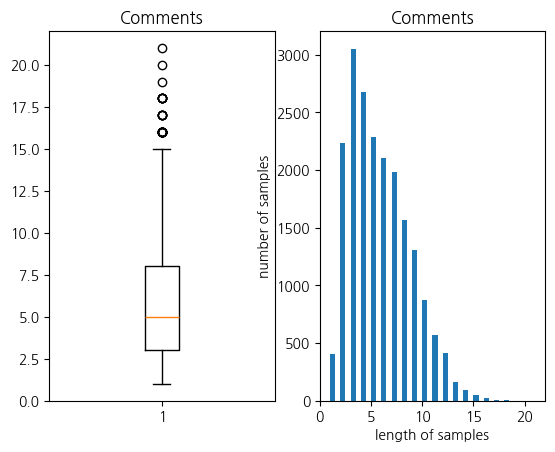

In [ ]:
import matplotlib.pyplot as plt

comments_len = [len(s.split()) for s in dataset_all['text']]

print('발화 최소 길이 : {}'.format(np.min(comments_len)))
print('발화 최대 길이 : {}'.format(np.max(comments_len)))
print('발화 평균 길이 : {}'.format(np.mean(comments_len)))

plt.subplot(1,2,1)
plt.boxplot(comments_len)
plt.title('Comments')

plt.subplot(1,2,2)
plt.title('Comments')
plt.hist(comments_len, bins=40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [ ]:
# 위험 상황인 것의 데이터만 추출
true_data = dataset_all[dataset_all['label'] == 1]

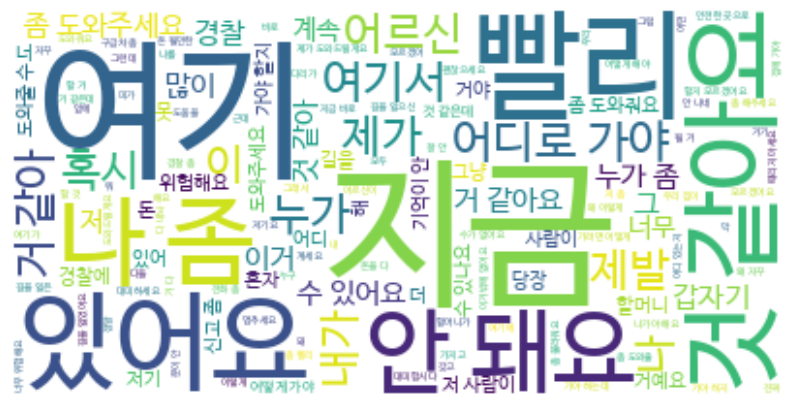

In [ ]:
from wordcloud import WordCloud
from PIL import Image

# bubble_mask = np.array(Image.open('/content/drive/MyDrive/project4/speech-bubble.PNG'))

wordcloud = WordCloud(
                    font_path='NanumBarunGothic',
                    #   mask=bubble_mask,
                      background_color='white')

# true label에 대한 word cloud 생성
wc_true = wordcloud.generate(' '.join(true_data['text']))

plt.figure(figsize=(10, 10))
plt.imshow(wc_true, cmap=plt.cm.gray, interpolation='bilinear')
plt.axis("off")

plt.show()

In [ ]:
# 정상 상황인 것의 데이터만 추출
false_data = dataset_all[dataset_all['label'] == 0]

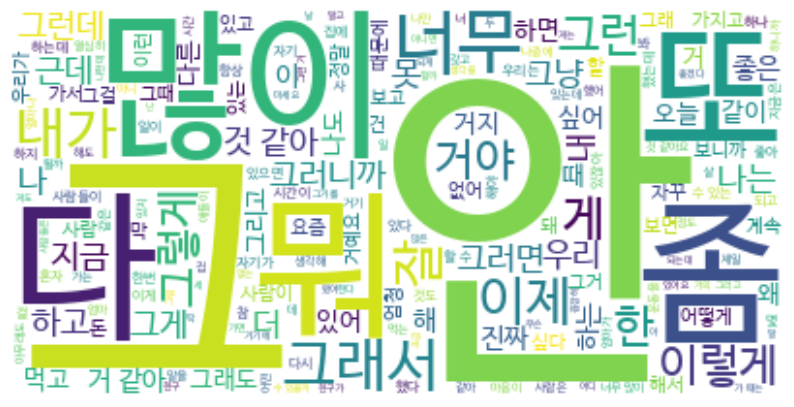

In [ ]:
from wordcloud import WordCloud
from PIL import Image

# bubble_mask = np.array(Image.open('/content/drive/MyDrive/project4/speech-bubble.PNG'))

wordcloud = WordCloud(
                    font_path='NanumBarunGothic',
                    #   mask=bubble_mask,
                      background_color='white')

# false label에 대한 word cloud 생성
wc_true = wordcloud.generate(' '.join(false_data['text']))

plt.figure(figsize=(10, 10))
plt.imshow(wc_true, cmap=plt.cm.gray, interpolation='bilinear')
plt.axis("off")

plt.show()

## 데이터셋 토큰화

In [ ]:
# ★ tokenizer, model 정의
tokenizer = KoBERTTokenizer.from_pretrained('skt/kobert-base-v1')
bertmodel = BertModel.from_pretrained('skt/kobert-base-v1', return_dict=False)
vocab = nlp.vocab.BERTVocab.from_sentencepiece(tokenizer.vocab_file, padding_token='[PAD]')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'XLNetTokenizer'. 
The class this function is called from is 'KoBERTTokenizer'.


In [ ]:
# 토크나이저가 잘 동작하는지 테스트
from torch import tensor

inputs = tokenizer("목차를 봤을 때 기억에 오래 남아요", return_tensors="pt")
print(inputs)

{'input_ids': tensor([[   2, 2068, 7389, 6116, 2421, 7088, 1844, 1291, 6896, 3422, 1420, 6999,
            3]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}


In [ ]:
# ★ 데이터프레임 리스트화
train_data_list = []
for q, label in zip(dataset_train['text'], dataset_train['label'])  :
    data = []
    data.append(q)
    data.append(str(label))

    train_data_list.append(data)

print(data)
print(train_data_list[:10])

['딴 거 뭐 할 줄 알아?', '0']
[['내가 길을 몰라 왜 길 잃어? 내가 여기 얼마나 자주 다녀 가지고 아는데 내가 길을 왜 모르는데.', '1'], ['헉', '0'], ['맨 처음부터 일한 사람은.', '0'], ['사람이 치여 가지고 아저씨께서 119 불러 달라 하셔서 지금 전화 드린 거거든요.', '1'], ['교회에서 만났어', '0'], ['줄 길거 같아', '0'], ['그러니까 애들 어릴 때 많이 들어서 영향이 큰 것 같아.', '0'], ['그러면 그런 아이들은 공부를 시켜서 사회에서 뭔가 할 수 있게 해야 되는데.', '0'], ['면도기 또 사야돼', '0'], ['핸드폰 중독인듯', '0']]


In [ ]:
# ★ 데이터프레임 리스트화
test_data_list = []
for q, label in zip(dataset_test['text'], dataset_test['label'])  :
    data = []
    data.append(q)
    data.append(str(label))

    test_data_list.append(data)

print(data)
print(test_data_list[:10])

['적당히를 몰라', '0']
[['왜, 왜 내 물건이 사라졌지? 누가 손을 댄 건가?', '1'], ['돈 없다고? 거짓말이면 네 다리 부러진다.', '1'], ['세탁소 가기 귀찮네', '0'], ['나는 모자란 사람인 거 같아', '0'], ['날 아들이 기다릴 텐데 어디로 갔지?', '1'], ['뒤에 그 두 돈 반 트럭에 장비 다 싣고 포 달고 다니고.', '0'], ['잘하실 거예요.', '0'], ['어려 보이고 싶어', '0'], ['다이어트를 해봐요.', '0'], ['새 집으로 이사 가기로 했어', '0']]


## 파라미터 셋팅

In [ ]:
max_len = 64
batch_size = 64
warmup_ratio = 0.1
num_epochs = 2
max_grad_norm = 1
log_interval = 200
learning_rate = 3e-5   ## 과적합 방지를 위해 테스트 후 조정 (5e-5 --> 3e-5)

## Data tokenization, int encoding, padding

### **BERTSentenceTransform 에러 : 해결**

    
* (1) 해당 클래스의 py 파일 경로 찾는 코드 실행
* (2) 경로에 <대략 1220>번째에 해당 클래스 존재. 블로그에 있는 코드로 복붙해서 대체해줄 것
    * 참고 : [BLOG : BertSentenceTransForm 에러](https://blog.naver.com/newyearchive/223097878715)
    * **--> 대체할 필요 없이 직접 밑 셀에 복붙해서 써도 괜찮아서 이대로 사용**
* (3) 이젠 다음 에러 존재 --> GPT에게 물어보니 df를 넣어서 그렇다 함. df를 리스트화해줌.
        valueerror: invalid literal for int() with base 10: 'e'
    * 참고 : [BLOG : KoBert 데이터 이해(tsv)](https://steminher.tistory.com/137)




In [ ]:
# (2번 방법. 사용 X)
# # ★ BERTSentenceTransform 클래스 에러로 수정하기 위해 위치 찾기
# import sys
# import inspect

# # 찾고자 하는 클래스 이름
# class_name = "BERTSentenceTransform"

# # sys.modules에서 모든 로드된 모듈을 순회하며 클래스가 있는지 확인
# for module_name, module in sys.modules.items():
#     if hasattr(module, class_name):
#         # 클래스가 발견되면 해당 모듈에서 클래스 정의 파일 경로를 출력
#         cls = getattr(module, class_name)
#         print(f"Class {class_name} found in module: {module_name}")
#         print(f"Class definition file: {inspect.getfile(cls)}")
#         break
# else:
#     print(f"Class {class_name} not found in any loaded modules.")

In [ ]:
class BERTSentenceTransform:
    r"""BERT style data transformation.

    Parameters
    ----------
    tokenizer : BERTTokenizer.
        Tokenizer for the sentences.
    max_seq_length : int.
        Maximum sequence length of the sentences.
    pad : bool, default True
        Whether to pad the sentences to maximum length.
    pair : bool, default True
        Whether to transform sentences or sentence pairs.
    """

    def __init__(self, tokenizer, max_seq_length,vocab, pad=True, pair=True):
        self._tokenizer = tokenizer
        self._max_seq_length = max_seq_length
        self._pad = pad
        self._pair = pair
        self._vocab = vocab

    def __call__(self, line):
        """Perform transformation for sequence pairs or single sequences.

        The transformation is processed in the following steps:
        - tokenize the input sequences
        - insert [CLS], [SEP] as necessary
        - generate type ids to indicate whether a token belongs to the first
        sequence or the second sequence.
        - generate valid length

        For sequence pairs, the input is a tuple of 2 strings:
        text_a, text_b.

        Inputs:
            text_a: 'is this jacksonville ?'
            text_b: 'no it is not'
        Tokenization:
            text_a: 'is this jack ##son ##ville ?'
            text_b: 'no it is not .'
        Processed:
            tokens: '[CLS] is this jack ##son ##ville ? [SEP] no it is not . [SEP]'
            type_ids: 0     0  0    0    0     0       0 0     1  1  1  1   1 1
            valid_length: 14

        For single sequences, the input is a tuple of single string:
        text_a.

        Inputs:
            text_a: 'the dog is hairy .'
        Tokenization:
            text_a: 'the dog is hairy .'
        Processed:
            text_a: '[CLS] the dog is hairy . [SEP]'
            type_ids: 0     0   0   0  0     0 0
            valid_length: 7

        Parameters
        ----------
        line: tuple of str
            Input strings. For sequence pairs, the input is a tuple of 2 strings:
            (text_a, text_b). For single sequences, the input is a tuple of single
            string: (text_a,).

        Returns
        -------
        np.array: input token ids in 'int32', shape (batch_size, seq_length)
        np.array: valid length in 'int32', shape (batch_size,)
        np.array: input token type ids in 'int32', shape (batch_size, seq_length)

        """

        # convert to unicode
        text_a = line[0]
        if self._pair:
            assert len(line) == 2
            text_b = line[1]

        tokens_a = self._tokenizer.tokenize(text_a)
        tokens_b = None

        if self._pair:
            tokens_b = self._tokenizer(text_b)

        if tokens_b:
            # Modifies `tokens_a` and `tokens_b` in place so that the total
            # length is less than the specified length.
            # Account for [CLS], [SEP], [SEP] with "- 3"
            self._truncate_seq_pair(tokens_a, tokens_b,
                                    self._max_seq_length - 3)
        else:
            # Account for [CLS] and [SEP] with "- 2"
            if len(tokens_a) > self._max_seq_length - 2:
                tokens_a = tokens_a[0:(self._max_seq_length - 2)]

        # The embedding vectors for `type=0` and `type=1` were learned during
        # pre-training and are added to the wordpiece embedding vector
        # (and position vector). This is not *strictly* necessary since
        # the [SEP] token unambiguously separates the sequences, but it makes
        # it easier for the model to learn the concept of sequences.

        # For classification tasks, the first vector (corresponding to [CLS]) is
        # used as as the "sentence vector". Note that this only makes sense because
        # the entire model is fine-tuned.
        #vocab = self._tokenizer.vocab
        vocab = self._vocab
        tokens = []
        tokens.append(vocab.cls_token)
        tokens.extend(tokens_a)
        tokens.append(vocab.sep_token)
        segment_ids = [0] * len(tokens)

        if tokens_b:
            tokens.extend(tokens_b)
            tokens.append(vocab.sep_token)
            segment_ids.extend([1] * (len(tokens) - len(segment_ids)))

        input_ids = self._tokenizer.convert_tokens_to_ids(tokens)

        # The valid length of sentences. Only real  tokens are attended to.
        valid_length = len(input_ids)

        if self._pad:
            # Zero-pad up to the sequence length.
            padding_length = self._max_seq_length - valid_length
            # use padding tokens for the rest
            input_ids.extend([vocab[vocab.padding_token]] * padding_length)
            segment_ids.extend([0] * padding_length)

        return np.array(input_ids, dtype='int32'), np.array(valid_length, dtype='int32'),\
            np.array(segment_ids, dtype='int32')

### BERTDataset

In [ ]:
from kobert_tokenizer import KoBERTTokenizer
from transformers import BertModel
from transformers import AdamW
from transformers.optimization import get_cosine_schedule_with_warmup

class BERTDataset(Dataset):
    def __init__(self, dataset, sent_idx, label_idx, bert_tokenizer, vocab, max_len,
                 pad, pair):
        transform = BERTSentenceTransform(bert_tokenizer, max_seq_length=max_len,vocab=vocab, pad=pad, pair=pair)
        #transform = nlp.data.BERTSentenceTransform(
        #    tokenizer, max_seq_length=max_len, pad=pad, pair=pair)
        self.sentences = [transform([i[sent_idx]]) for i in dataset]
        self.labels = [np.int32(i[label_idx]) for i in dataset]

    def __getitem__(self, i):
        return (self.sentences[i] + (self.labels[i], ))

    def __len__(self):
        return (len(self.labels))

tokenizer = KoBERTTokenizer.from_pretrained('skt/kobert-base-v1')
bertmodel = BertModel.from_pretrained('skt/kobert-base-v1', return_dict=False)
vocab = nlp.vocab.BERTVocab.from_sentencepiece(tokenizer.vocab_file, padding_token='[PAD]')

# BERTDataset : 각 데이터가 BERT 모델의 입력으로 들어갈 수 있도록
# tokenization, int encoding, padding하는 함수
data_train = BERTDataset(train_data_list, 0, 1, tokenizer, vocab, max_len, True, False)
data_test = BERTDataset(test_data_list, 0, 1, tokenizer, vocab, max_len, True, False)

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'XLNetTokenizer'. 
The class this function is called from is 'KoBERTTokenizer'.


In [ ]:
# torch 형식의 dataset을 만들어 입력 데이터셋의 전처리 마무리
train_dataloader = torch.utils.data.DataLoader(data_train, batch_size = batch_size, num_workers = 5)
test_dataloader = torch.utils.data.DataLoader(data_test, batch_size = batch_size, num_workers = 5)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


# Kobert 모델 구현

## 모델 불러오기

In [ ]:
class BERTClassifier(nn.Module):
    def __init__(self,
                 bert,
                 hidden_size = 768,
                 num_classes = 2,   # 분류할 클래스 수로 조정
                 dr_rate = None,
                 params = None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate

        self.classifier = nn.Linear(hidden_size , num_classes)
        if dr_rate:
            self.dropout = nn.Dropout(p = dr_rate)

    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)

        _, pooler = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device),return_dict = False)
        if self.dr_rate:
            out = self.dropout(pooler)
        return self.classifier(out)

optimizer와 schedule 설정

In [ ]:
# BERT  모델 불러오기 (과적합 방지를 위해 테스트 후 드롭아웃 조정. 0.5 --> 0.6)
model = BERTClassifier(bertmodel, dr_rate = 0.6).to(device)

In [ ]:
# optimizer와 schedule 설정
# Prepare optimizer and schedule (linear warmup and decay)
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]


optimizer = AdamW(optimizer_grouped_parameters, lr = learning_rate)
loss_fn = nn.CrossEntropyLoss() # 다중분류를 위한 loss function

t_total = len(train_dataloader) * num_epochs
warmup_step = int(t_total * warmup_ratio)

scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps = warmup_step, num_training_steps = t_total)

# calc_accuracy : 정확도 측정을 위한 함수
def calc_accuracy(X,Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc

train_dataloader

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


## 학습

In [ ]:
# 학습 코드 (학습 곡선 그리기 위해 list에 담음)

train_losses = []
train_accuracies = []
test_accuracies = []
test_losses = []  ### 추가: 검증 손실을 저장할 리스트

for e in range(num_epochs):
    train_acc = 0.0
    train_loss = 0.0
    test_acc = 0.0
    test_loss = 0.0  ### 추가: 검증 손실을 저장하기 위한 변수
    model.train()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):
        optimizer.zero_grad()
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        loss = loss_fn(out, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()  # Update learning rate schedule
        train_acc += calc_accuracy(out, label)

        train_loss += loss.item()

        if batch_id % log_interval == 0:
            print("epoch {} batch id {} loss {} train acc {}".format(e+1, batch_id+1, loss.data.cpu().numpy(), train_acc / (batch_id+1)))

     # 에포크별 평균 손실과 정확도를 저장
    avg_train_loss = train_loss / len(train_dataloader)
    avg_train_acc = train_acc / len(train_dataloader)
    train_losses.append(avg_train_loss)
    train_accuracies.append(avg_train_acc)


    # print("epoch {} train acc {}".format(e+1, train_acc / (batch_id+1)))
    print("epoch {} train acc {} train loss {}".format(e+1, avg_train_acc, avg_train_loss))

    model.eval()

    with torch.no_grad():
        for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(test_dataloader)):
            token_ids = token_ids.long().to(device)
            segment_ids = segment_ids.long().to(device)
            valid_length= valid_length
            label = label.long().to(device)
            out = model(token_ids, valid_length, segment_ids)
            test_loss += loss_fn(out, label).item()  # 검증 손실 계산
            test_acc += calc_accuracy(out, label)

    avg_test_acc = test_acc / len(test_dataloader)
    avg_test_loss = test_loss / len(test_dataloader)  # 평균 검증 손실 계산
    test_accuracies.append(avg_test_acc)
    test_losses.append(avg_test_loss)  # 추가: 검증 손실을 리스트에 추가

    # print("epoch {} test acc {}".format(e+1, test_acc / (batch_id+1)))
    # print("epoch {} test acc {}".format(e+1, avg_test_acc))
    print("epoch {} test acc {} test loss {}".format(e+1, avg_test_acc, avg_test_loss))  # 추가: 검증 손실 출력


<ipython-input-91-b38f59f3db14>:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):


  0%|          | 0/186 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


epoch 1 batch id 1 loss 0.37594592571258545 train acc 0.96875
epoch 1 train acc 0.9812107974910395 train loss 0.09585954461957738


<ipython-input-91-b38f59f3db14>:46: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(test_dataloader)):


  0%|          | 0/62 [00:00<?, ?it/s]

epoch 1 test acc 0.9684197719688543 test loss 0.1043394370560324


  0%|          | 0/186 [00:00<?, ?it/s]

epoch 2 batch id 1 loss 0.04052191972732544 train acc 0.984375
epoch 2 train acc 0.9969758064516129 train loss 0.015154863705217679


  0%|          | 0/62 [00:00<?, ?it/s]

epoch 2 test acc 0.983062778086763 test loss 0.07517058361178985


In [ ]:
train_accuracies

[0.9812107974910395, 0.9969758064516129]

In [ ]:
test_accuracies

[0.9684197719688543, 0.983062778086763]

In [ ]:
train_losses

[0.09585954461957738, 0.015154863705217679]

In [ ]:
test_losses

[0.1043394370560324, 0.07517058361178985]

In [ ]:
# accuracy & loss 데이터프레임으로 변환 및 저장

# 데이터프레임 생성
df_history = pd.DataFrame({
    'epoch': range(1, num_epochs + 1),
    'loss': train_losses,
    'val_loss': test_losses,
    'accuracy': train_accuracies,
    'val_accuracy': test_accuracies
})
df_history.set_index(keys='epoch', inplace = True)
df_history

,loss,val_loss,accuracy,val_accuracy
epoch,,,,
1,0.095860,0.104339,0.981211,0.968420
2,0.015155,0.075171,0.996976,0.983063


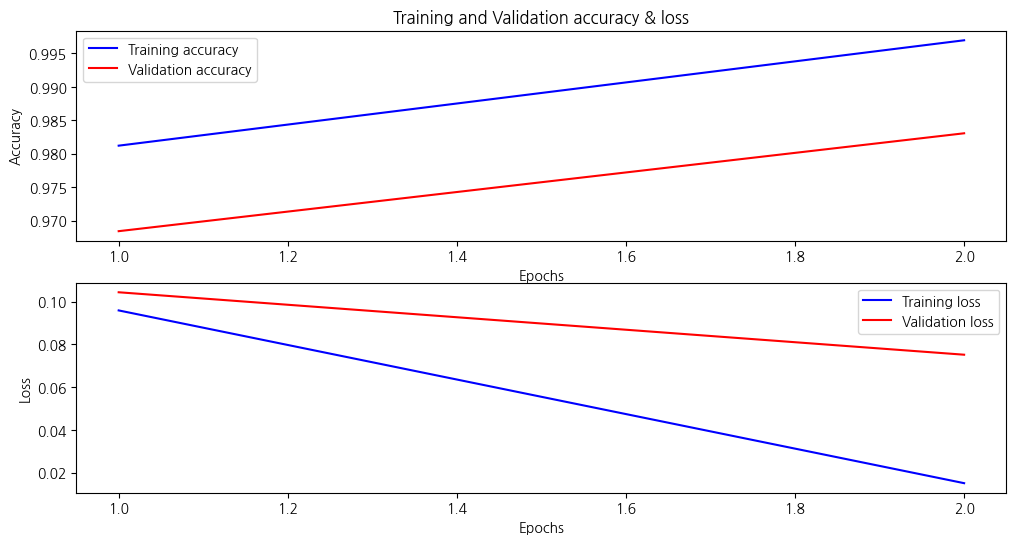

In [ ]:
# 학습 곡선을 그리기
import matplotlib.pyplot as plt

epochs = range(1, num_epochs + 1)

# plt.figure(figsize=(12, 6))
fig = plt.figure(figsize=(12, 6))
# fig.tight_layout()

# 학습 및 검증 정확도 곡선
plt.subplot(2, 1, 1)
plt.plot(epochs, train_accuracies, 'b', label='Training accuracy')
plt.plot(epochs, test_accuracies, 'r', label='Validation accuracy')
plt.title('Training and Validation accuracy & loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# 학습 및 검증 손실 곡선
plt.subplot(2, 1, 2)  ### 추가: 학습 손실과 검증 손실을 그리기 위한 서브플롯
plt.plot(epochs, train_losses, 'b', label='Training loss')
plt.plot(epochs, test_losses, 'r', label='Validation loss')  ### 추가: 검증 손실 곡선
# plt.title('Training and Validation loss')  ### 추가: 손실 그래프 제목
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

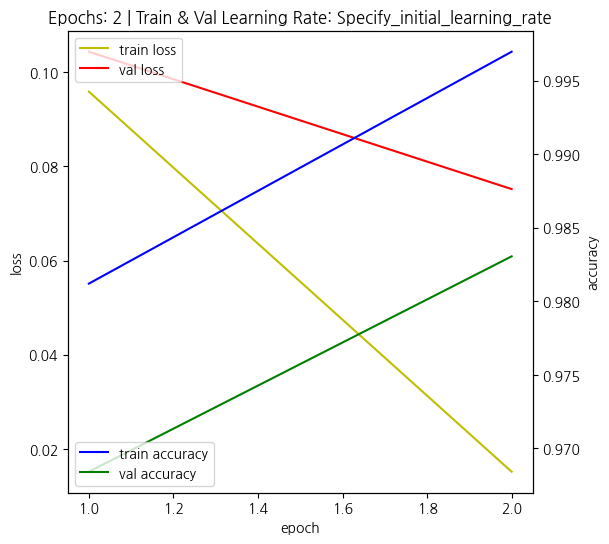

In [ ]:
import matplotlib.pyplot as plt

# 그래프 그리기
fig, loss_ax = plt.subplots(figsize=(6, 6))
acc_ax = loss_ax.twinx()

# 학습 손실과 검증 손실
loss_ax.plot(df_history.index, df_history['loss'], 'y', label='train loss')
loss_ax.plot(df_history.index, df_history['val_loss'], 'r', label='val loss')

# 학습 정확도와 검증 정확도
acc_ax.plot(df_history.index, df_history['accuracy'], 'b', label='train accuracy')
acc_ax.plot(df_history.index, df_history['val_accuracy'], 'g', label='val accuracy')

# 라벨 설정
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')

# 범례 위치 설정
loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

# 제목 추가
epochs = df_history.index[-1]
init_lr = "Specify_initial_learning_rate"  # 초기 학습률 값을 지정
plt.title(f"Epochs: {epochs} | Train & Val Learning Rate: {init_lr}")

plt.show()


## 직접 문장 넣어 테스트

In [ ]:
def predict(predict_sentence): # input = 감정분류하고자 하는 sentence

    data = [predict_sentence, '0']
    dataset_another = [data]

    another_test = BERTDataset(dataset_another, 0, 1, tokenizer, vocab, max_len, True, False) # 토큰화한 문장
    test_dataloader = torch.utils.data.DataLoader(another_test, batch_size = batch_size, num_workers = 5) # torch 형식 변환

    model.eval()

    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(test_dataloader):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)

        valid_length = valid_length
        label = label.long().to(device)

        out = model(token_ids, valid_length, segment_ids)


        test_eval = []
        for i in out: # out = model(token_ids, valid_length, segment_ids)
            logits = i
            logits = logits.detach().cpu().numpy()
            print(logits)

            if np.argmax(logits) == 0:
                test_eval.append("정상 상황🌱")
            elif np.argmax(logits) == 1:
                test_eval.append("위험 상황⚡")

        print(">> 입력하신 내용은 \"" + test_eval[0] + "\"으로 보여집니다. ")

In [ ]:
# 질문에 0 입력 시 종료
end = 1
while end == 1 :
    sentence = input("하고싶은 말을 입력해주세요 : ")
    if sentence == "0" :
        break
    predict(sentence)
    print("\n")

# 예측

## 예측 데이터 준비

In [ ]:
# ★ 데이터프레임 리스트화
predict_data_list = []
for q, label in zip(dataset_predict['text'], dataset_predict['label'])  :
    data = []
    data.append(q)
    data.append(str(label))

    predict_data_list.append(data)

print(data)
print(predict_data_list[:10])

['이사를 가면 출퇴근 시간이 많이 걸린다.', '0']
[['급한 상황입니다. 경찰을 불러주세요.', '1'], ['위험을 감지했어요. 경찰에 신고해 주세요.', '1'], ['그냥 버석버석거리던 데 사람들이 엄청 좋아하더라고.', '0'], ['그래서 우리는 이제 술 한 잔 먹고 이제 기분 좋게 있는데.', '0'], ['뭔가 찾고 계신 건가요? 제가 도와드릴게요.', '1'], ['그렇지 우리나라도 바뀌기는 해야 되는데.', '0'], ['어디서부터 잘못된 걸까', '0'], ['속았나', '0'], ['그때는 우리가 형제들이 다섯 명  여섯 명 이렇게 되고 했었잖아.', '0'], ['대놓고 말했으면 좋겠어', '0']]


In [ ]:
# BERTDataset : 각 데이터가 BERT 모델의 입력으로 들어갈 수 있도록 tokenization, int encoding, padding하는 함수
data_predict = BERTDataset(predict_data_list, 0, 1, tokenizer, vocab, max_len, True, False)

In [ ]:
# torch 형식의 dataset을 만들어 입력 데이터셋의 전처리 마무리
predict_dataloader = torch.utils.data.DataLoader(data_predict, batch_size = batch_size, num_workers = 5)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
all_predictions = []
test_acc = 0.0
total_loss = 0.0

model.eval()
for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(predict_dataloader)):
    token_ids = token_ids.long().to(device)
    segment_ids = segment_ids.long().to(device)
    valid_length= valid_length
    label = label.long().to(device)
    out = model(token_ids, valid_length, segment_ids)

    # 정확도 & 손실 계산
    test_acc += calc_accuracy(out, label)
    loss = loss_fn(out, label)  # 모델의 예측 결과와 실제 레이블로 손실 계산
    total_loss += loss.item()  # 손실 값을 누적

    predictions = torch.argmax(out, dim=-1)
    all_predictions.extend(predictions.cpu().numpy())
print("prediction acc {}".format(test_acc / (batch_id+1)))
print("prediction loss {}".format(total_loss / (batch_id+1)))

<ipython-input-108-25e690604f27>:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(predict_dataloader)):


  0%|          | 0/62 [00:00<?, ?it/s]

prediction acc 0.9609038978494624
prediction loss 0.20386310878975858


In [ ]:
# 결과를 DataFrame에 추가
dataset_predict['predicted_label'] = all_predictions

## 혼동행렬 & f1점수

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score

print(accuracy_score(dataset_predict['label'], dataset_predict['predicted_label']))

cm=confusion_matrix(dataset_predict['label'], dataset_predict['predicted_label'])
cm

0.9608980827447023


array([[2551,   49],
       [ 106, 1258]])

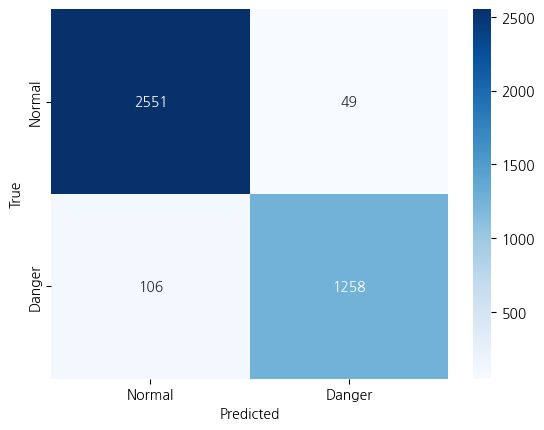

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# 예측 결과 & 실제 레이블을 가져오기
true_labels = dataset_predict['label'].tolist()
predicted_labels = dataset_predict['predicted_label'].tolist()
cm = confusion_matrix(true_labels, predicted_labels)

# 혼동행렬 시각화
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Danger'], yticklabels=['Normal', 'Danger'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
# 분류 보고서 출력
print("Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=['Normal', 'Danger']))

Classification Report:
              precision    recall  f1-score   support

      Normal       0.96      0.98      0.97      2600
      Danger       0.96      0.92      0.94      1364

    accuracy                           0.96      3964
   macro avg       0.96      0.95      0.96      3964
weighted avg       0.96      0.96      0.96      3964



## predict 데이터 - 잘못 예측된 것

In [ ]:
# 잘못 예측된 데이터 필터링
incorrect_predictions = dataset_predict[dataset_predict['label'] != dataset_predict['predicted_label']]

# 잘못 예측된 데이터 출력
print("잘못 예측된 데이터:")
print(incorrect_predictions)

# 잘못 예측된 데이터 개수
incorrect_count = len(incorrect_predictions)
print(f"\n잘못 예측된 데이터 개수: {incorrect_count}")

잘못 예측된 데이터:
                             text  label  predicted_label
19            어 그래 너 나중에 나한테 좀 맞자      1                0
39                 오랜만에 힘 좀 써야하네.      1                0
58          이 새끼 귀 뜯어서 벽에 걸어놀라니깐.      1                0
127   야 나 오늘 지갑을 안가져왔는데 5만원만 빌려주라      1                0
147            머리가 띵한게 한 대 맞은거 같아      0                1
...                           ...    ...              ...
3869           전화는 왜 갖고 다녀. 안받으면서      0                1
3887                   으이구 병신 새끼!      1                0
3894           스트레스 받으시는 일 있으신거죠.      0                1
3926                칼로 쑤시는 맛이 있거든      1                0
3947                 이거 정말 큰일이네요.      0                1

[155 rows x 3 columns]

잘못 예측된 데이터 개수: 155


In [ ]:
incorrect_predictions

,text,label,predicted_label
19,어 그래 너 나중에 나한테 좀 맞자,1,0
39,오랜만에 힘 좀 써야하네.,1,0
58,이 새끼 귀 뜯어서 벽에 걸어놀라니깐.,1,0
127,야 나 오늘 지갑을 안가져왔는데 5만원만 빌려주라,1,0
147,머리가 띵한게 한 대 맞은거 같아,0,1
...,...,...,...
3869,전화는 왜 갖고 다녀. 안받으면서,0,1
3887,으이구 병신 새끼!,1,0
3894,스트레스 받으시는 일 있으신거죠.,0,1
3926,칼로 쑤시는 맛이 있거든,1,0


## 검증 데이터로 혼동행렬

In [ ]:
test_dataloader

In [ ]:
dataset_test

,text,label,predicted_label
0,"왜, 왜 내 물건이 사라졌지? 누가 손을 댄 건가?",1,1
1,돈 없다고? 거짓말이면 네 다리 부러진다.,1,1
2,세탁소 가기 귀찮네,0,0
3,나는 모자란 사람인 거 같아,0,0
4,날 아들이 기다릴 텐데 어디로 갔지?,1,1
...,...,...,...
3957,밥생각이 없어,0,0
3958,적당해요.,0,0
3959,건강 생각해서 챙겨드세요.,0,0
3960,약 바르고 얼른 나으세요.,0,0


In [ ]:
all_predictions = []
test_acc = 0.0
total_loss = 0.0

model.eval()
for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(test_dataloader)):
    token_ids = token_ids.long().to(device)
    segment_ids = segment_ids.long().to(device)
    valid_length= valid_length
    label = label.long().to(device)
    out = model(token_ids, valid_length, segment_ids)

    # 정확도 & 손실 계산
    test_acc += calc_accuracy(out, label)
    loss = loss_fn(out, label)  # 모델의 예측 결과와 실제 레이블로 손실 계산
    total_loss += loss.item()  # 손실 값을 누적

    predictions = torch.argmax(out, dim=-1)
    all_predictions.extend(predictions.cpu().numpy())
print("valid acc {}".format(test_acc / (batch_id+1)))
print("valid loss {}".format(total_loss / (batch_id+1)))

<ipython-input-117-c1b0c5e5b177>:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(test_dataloader)):


  0%|          | 0/62 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


valid acc 0.983062778086763
valid loss 0.07517058361178985


In [ ]:
# 결과를 DataFrame에 추가
dataset_test['predicted_label'] = all_predictions

In [ ]:
dataset_test

,text,label,predicted_label
0,"왜, 왜 내 물건이 사라졌지? 누가 손을 댄 건가?",1,1
1,돈 없다고? 거짓말이면 네 다리 부러진다.,1,1
2,세탁소 가기 귀찮네,0,0
3,나는 모자란 사람인 거 같아,0,0
4,날 아들이 기다릴 텐데 어디로 갔지?,1,1
...,...,...,...
3957,밥생각이 없어,0,0
3958,적당해요.,0,0
3959,건강 생각해서 챙겨드세요.,0,0
3960,약 바르고 얼른 나으세요.,0,0


In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score

print(accuracy_score(dataset_test['label'], dataset_test['predicted_label']))

cm=confusion_matrix(dataset_test['label'], dataset_test['predicted_label'])
cm

0.9830893488137304


array([[2556,   44],
       [  23, 1339]])

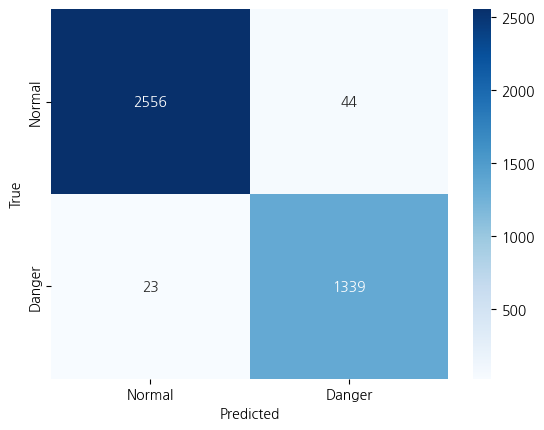

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

true_labels = dataset_test['label'].tolist()
predicted_labels = dataset_test['predicted_label'].tolist().
cm = confusion_matrix(true_labels, predicted_labels)

# 혼동행렬 시각화
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Danger'], yticklabels=['Normal', 'Danger'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
# 분류 보고서 출력
print("Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=['Normal', 'Danger']))

Classification Report:
              precision    recall  f1-score   support

      Normal       0.99      0.98      0.99      2600
      Danger       0.97      0.98      0.98      1362

    accuracy                           0.98      3962
   macro avg       0.98      0.98      0.98      3962
weighted avg       0.98      0.98      0.98      3962



## ROC-AUC 값

<ipython-input-123-8534c71c5ff2>:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(predict_dataloader)):


  0%|          | 0/62 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


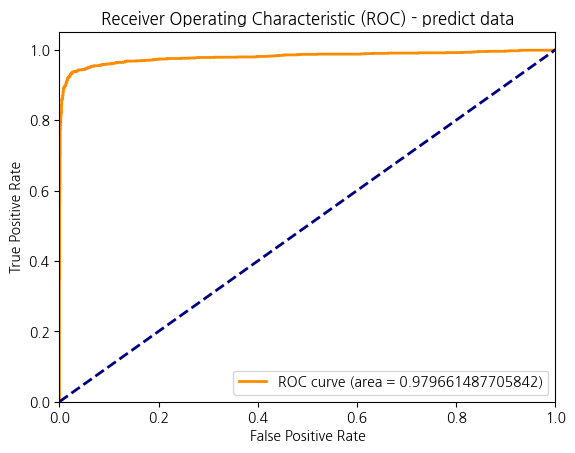

ROC-AUC: 0.979661487705842


In [ ]:
import torch
import torch.nn.functional as F
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# 예측 확률과 실제 레이블을 저장할 리스트
all_probs = []
all_labels = []

model.eval()
with torch.no_grad():
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(predict_dataloader)):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length = valid_length.to(device)
        label = label.long().to(device)

        # 모델 예측
        out = model(token_ids, valid_length, segment_ids)

        # softmax를 사용해 클래스 확률 계산
        probs = F.softmax(out, dim=1)

        # 클래스(1)의 확률만 저장
        all_probs.extend(probs[:, 1].cpu().numpy())
        all_labels.extend(label.cpu().numpy())

# ROC 곡선 계산
fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
roc_auc = roc_auc_score(all_labels, all_probs)

# ROC 곡선 그리기
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.15f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - predict data')
plt.legend(loc="lower right")
plt.show()

# AUC 값 출력
print(f"ROC-AUC: {roc_auc:.15f}")

<ipython-input-124-367aa67ff68e>:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):


  0%|          | 0/186 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


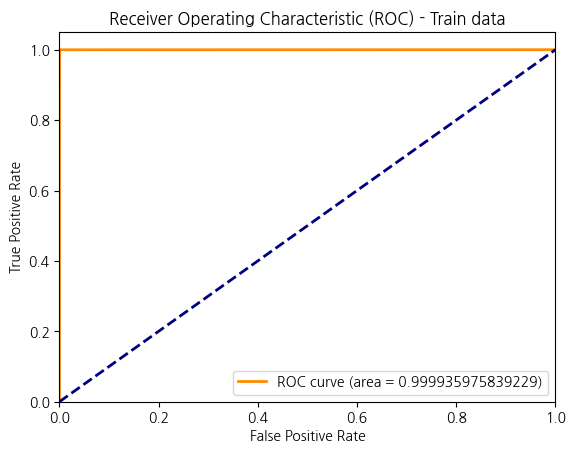

훈련 데이터 ROC-AUC: 0.999935975839229


In [ ]:
import torch
import torch.nn.functional as F
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# 예측 확률과 실제 레이블을 저장할 리스트
all_probs = []
all_labels = []

model.eval()
with torch.no_grad():
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length = valid_length.to(device)
        label = label.long().to(device)

        # 모델을 통해 예측값 얻기
        out = model(token_ids, valid_length, segment_ids)

        # softmax를 사용해 클래스 확률 계산
        probs = F.softmax(out, dim=1)

        # 클래스(1)의 확률만 저장
        all_probs.extend(probs[:, 1].cpu().numpy())
        all_labels.extend(label.cpu().numpy())

# ROC 곡선 계산
fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
roc_auc = roc_auc_score(all_labels, all_probs)

# ROC 곡선 그리기
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.15f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - Train data')
plt.legend(loc="lower right")
plt.show()

# AUC 값 출력
print(f"훈련 데이터 ROC-AUC: {roc_auc:.15f}")

<ipython-input-125-4b8b54851bf7>:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(test_dataloader)):


  0%|          | 0/62 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


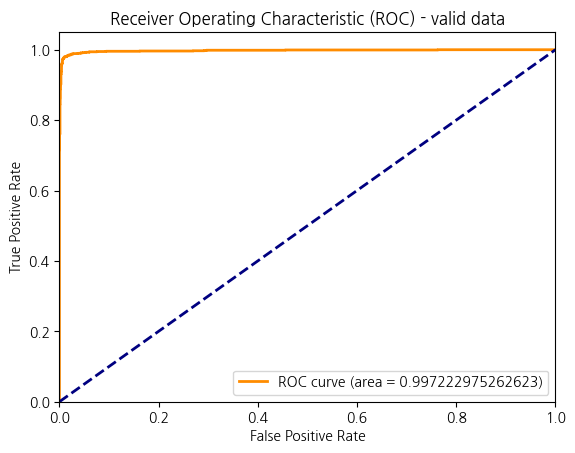

검증 데이터 ROC-AUC: 0.997222975262623


In [ ]:
import torch
import torch.nn.functional as F
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# 예측 확률과 실제 레이블을 저장할 리스트
all_probs = []
all_labels = []

model.eval()
with torch.no_grad():
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(test_dataloader)):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length = valid_length.to(device)
        label = label.long().to(device)

        # 모델을 통해 예측값 얻기
        out = model(token_ids, valid_length, segment_ids)

        # softmax를 사용해 클래스 확률 계산
        probs = F.softmax(out, dim=1)

        # 클래스(1)의 확률만 저장
        all_probs.extend(probs[:, 1].cpu().numpy())
        all_labels.extend(label.cpu().numpy())

# ROC 곡선 계산
fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
roc_auc = roc_auc_score(all_labels, all_probs)

# ROC 곡선 그리기
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.15f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - valid data')
plt.legend(loc="lower right")
plt.show()

# AUC 값 출력
print(f"검증 데이터 ROC-AUC: {roc_auc:.15f}")

# 드라이브에 모델 저장

In [ ]:
# 모델 저장
torch.save(model.state_dict(), '/content/drive/MyDrive/2024 학교/졸작 준비/인공지능/11.05_KoBert_state_dict.pth')

## 저장된 모델 불러오기

In [ ]:
#구글드라이브 연동
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from kobert_tokenizer import KoBERTTokenizer
from transformers import BertModel
from transformers import AdamW
from transformers.optimization import get_cosine_schedule_with_warmup

class BERTDataset(Dataset):
    def __init__(self, dataset, sent_idx, label_idx, bert_tokenizer, vocab, max_len,
                 pad, pair):
        transform = BERTSentenceTransform(bert_tokenizer, max_seq_length=max_len,vocab=vocab, pad=pad, pair=pair)
        #transform = nlp.data.BERTSentenceTransform(
        #    tokenizer, max_seq_length=max_len, pad=pad, pair=pair)
        self.sentences = [transform([i[sent_idx]]) for i in dataset]
        self.labels = [np.int32(i[label_idx]) for i in dataset]

    def __getitem__(self, i):
        return (self.sentences[i] + (self.labels[i], ))

    def __len__(self):
        return (len(self.labels))

tokenizer = KoBERTTokenizer.from_pretrained('skt/kobert-base-v1')
bertmodel = BertModel.from_pretrained('skt/kobert-base-v1', return_dict=False)
vocab = nlp.vocab.BERTVocab.from_sentencepiece(tokenizer.vocab_file, padding_token='[PAD]')

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'XLNetTokenizer'. 
The class this function is called from is 'KoBERTTokenizer'.


In [ ]:
class BERTClassifier(nn.Module):
    def __init__(self,
                 bert,
                 hidden_size = 768,
                 num_classes = 2,   # 분류할 클래스 수로 조정
                 dr_rate = None,
                 params = None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate

        self.classifier = nn.Linear(hidden_size , num_classes)
        if dr_rate:
            self.dropout = nn.Dropout(p = dr_rate)

    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)

        _, pooler = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device),return_dict = False)
        if self.dr_rate:
            out = self.dropout(pooler)
        return self.classifier(out)

In [ ]:
# device = torch.device("cpu")
# GPU 사용 시
device = torch.device("cuda:0")

In [ ]:
# BERTClassifier 모델 정의 (모델 아키텍처가 저장된 것과 동일해야 함)
# 드롭아웃 비율 (0.6로 조정)
model = BERTClassifier(bertmodel, dr_rate=0.6).to(device)

# 저장된 모델 상태 불러오기
model.load_state_dict(torch.load('/content/drive/MyDrive/2024 학교/졸작 준비/인공지능/11.05_KoBert_state_dict.pth'))

# 모델을 평가 모드로 전환
model.eval()

<ipython-input-86-3f734a6cd841>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/drive/MyDrive/2024 학교/졸작 준비/인공지능/11.05_KoBert_sta

BERTClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(8002, 768, padding_idx=1)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise

In [ ]:
max_len = 64
batch_size = 64

In [ ]:
def predict(predict_sentence):

    data = [predict_sentence, '0']
    dataset_another = [data]

    another_test = BERTDataset(dataset_another, 0, 1, tokenizer, vocab, max_len, True, False) # 토큰화한 문장
    test_dataloader = torch.utils.data.DataLoader(another_test, batch_size = batch_size, num_workers = 5) # torch 형식 변환

    model.eval()

    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(test_dataloader):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)

        valid_length = valid_length
        label = label.long().to(device)

        out = model(token_ids, valid_length, segment_ids)


        test_eval = []
        for i in out: # out = model(token_ids, valid_length, segment_ids)
            logits = i
            logits = logits.detach().cpu().numpy()
            print(logits)

            if np.argmax(logits) == 0:
                test_eval.append("정상 상황")
            elif np.argmax(logits) == 1:
                test_eval.append("!!위험 상황!!")

        print(">> 입력하신 내용은 \"" + test_eval[0] + "\"으로 보여집니다. ")

In [ ]:
sentence = "점심은 챙겼지. 손녀가 학교에서 빵 가져와서 그걸로."
predict(sentence)

[ 4.3698187 -4.178288 ]
>> 입력하신 내용은 "정상 상황"으로 보여집니다. 


In [ ]:
sentence = "여기가 어디지? 이쪽 골목이 아니었나. 길을 못 찾겠네."
predict(sentence)

[-4.0894     4.0159807]
>> 입력하신 내용은 "위험 상황⚡"으로 보여집니다. 


In [ ]:
# 질문에 0 입력 시 종료
end = 1
while end == 1 :
    sentence = input("하고싶은 말을 입력해주세요 : ")
    if sentence == "0" :
        break
    predict(sentence)
    print("\n")

하고싶은 말을 입력해주세요 : 저 범죄자가 어르신을 강제로 추행하는 거 같아요
[-4.12967    4.0369496]
>> 입력하신 내용은 "위험 상황⚡"으로 보여집니다. 


하고싶은 말을 입력해주세요 : 안녕하세요 점심 드셨어요?
[ 4.3608875 -4.2190266]
>> 입력하신 내용은 "정상 상황🌱"으로 보여집니다. 


하고싶은 말을 입력해주세요 : 할머니 위험해요
[ 3.864453 -3.917403]
>> 입력하신 내용은 "정상 상황🌱"으로 보여집니다. 


하고싶은 말을 입력해주세요 : 할머니 위험해요!
[-4.246082   4.0319357]
>> 입력하신 내용은 "위험 상황⚡"으로 보여집니다. 


하고싶은 말을 입력해주세요 : 딸네 집에 갈라고 했는데 여기가 어디지?
[-4.1947784  4.064302 ]
>> 입력하신 내용은 "위험 상황⚡"으로 보여집니다. 


하고싶은 말을 입력해주세요 : 요즘엔 임영웅인가 좋더라.
[ 4.3630767 -4.1535916]
>> 입력하신 내용은 "정상 상황🌱"으로 보여집니다. 


하고싶은 말을 입력해주세요 : 말복이니까 닭 먹었지 어제는.
[ 4.367148  -4.1625867]
>> 입력하신 내용은 "정상 상황🌱"으로 보여집니다. 


하고싶은 말을 입력해주세요 : 0


In [ ]:
### logits말고, 소프트 맥스로 테스트하게끔 수정
import torch
import numpy as np
import torch.nn.functional as F

# 소수점 7자리로 설정
np.set_printoptions(precision=7, suppress=True)

def predict(predict_sentence):  # 감정 분류하고자 하는 문장 입력
    data = [predict_sentence, '0']
    dataset_another = [data]

    # BERTDataset 호출로 데이터 토큰화 및 처리
    another_test = BERTDataset(dataset_another, 0, 1, tokenizer, vocab, max_len, True, False)
    test_dataloader = torch.utils.data.DataLoader(another_test, batch_size=batch_size, num_workers=5)

    model.eval()

    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(test_dataloader):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        label = label.long().to(device)

        # 모델로부터 로짓(logits) 출력
        with torch.no_grad():
            out = model(token_ids, valid_length, segment_ids)

        test_eval = []
        for i in out:  # 각 출력값에 대해
            logits = i.detach().cpu().numpy()  # 로짓을 numpy 배열로 변환
            softmax_output = F.softmax(torch.tensor(logits), dim=-1).numpy()  # Softmax 적용하여 확률로 변환
            print("Logits:", logits)
            print("Softmax Output:", softmax_output)  # Softmax로 변환된 값 출력

            if np.argmax(softmax_output) == 0:
                test_eval.append("정상 상황🌱")
            elif np.argmax(softmax_output) == 1:
                test_eval.append("위험 상황⚡")

        print(">> 입력하신 내용은 \"" + test_eval[0] + "\"으로 보여집니다.")


In [ ]:
# 질문에 0 입력 시 종료
end = 1
while end == 1 :
    sentence = input("하고싶은 말을 입력해주세요 : ")
    if sentence == "0" :
        break
    predict(sentence)
    print("\n")

하고싶은 말을 입력해주세요 : 할머니 위험해요!
Logits: [-4.246082   4.0319357]
Softmax Output: [0.000254 0.999746]
>> 입력하신 내용은 "위험 상황⚡"으로 보여집니다.


하고싶은 말을 입력해주세요 : 안녕하세요 점심 드셨어요?
Logits: [ 4.3608875 -4.2190266]
Softmax Output: [0.9998122 0.0001878]
>> 입력하신 내용은 "정상 상황🌱"으로 보여집니다.


하고싶은 말을 입력해주세요 : 결혼할 때는 좋았지
Logits: [ 4.35104   -4.1434755]
Softmax Output: [0.9997955 0.0002045]
>> 입력하신 내용은 "정상 상황🌱"으로 보여집니다.


하고싶은 말을 입력해주세요 : 딸네 집에 갈라고 했는데 여기가 어디지?
Logits: [-4.1947784  4.064302 ]
Softmax Output: [0.0002588 0.9997411]
>> 입력하신 내용은 "위험 상황⚡"으로 보여집니다.


하고싶은 말을 입력해주세요 : 요즘에 임영웅인가 좋더라.
Logits: [ 4.3629055 -4.154992 ]
Softmax Output: [0.9998001 0.0001998]
>> 입력하신 내용은 "정상 상황🌱"으로 보여집니다.


하고싶은 말을 입력해주세요 : 말복이니까 닭 먹었지 어제는
Logits: [ 4.3634315 -4.1505585]
Softmax Output: [0.9997994 0.0002006]
>> 입력하신 내용은 "정상 상황🌱"으로 보여집니다.


하고싶은 말을 입력해주세요 : 0


# 허깅페이스에 모델 저장

In [ ]:
!pip install transformers huggingface_hub

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

위 명령어를 실행하면 Hugging Face에 로그인할 수 있는 팝업이 뜹니다. 이때, 개인 Access Token을 넣어주면 됩니다.

In [ ]:
import torch
import torch.nn as nn
from transformers import BertModel, BertConfig, PreTrainedModel

class BERTClassifier(PreTrainedModel):
    def __init__(self, bert, hidden_size=768, num_classes=2, dr_rate=None, params=None):
        super(BERTClassifier, self).__init__(config=params)  # config를 전달하여 초기화
        self.bert = bert
        self.dr_rate = dr_rate

        self.classifier = nn.Linear(hidden_size, num_classes)
        if dr_rate:
            self.dropout = nn.Dropout(p=dr_rate)

    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)
        _, pooler = self.bert(input_ids=token_ids,
                              token_type_ids=segment_ids.long(),
                              attention_mask=attention_mask.float().to(token_ids.device),
                              return_dict=False)
        if self.dr_rate:
            out = self.dropout(pooler)
        return self.classifier(out)

# 모델의 설정을 가져오기
config = BertConfig.from_pretrained('skt/kobert-base-v1')

# 모델을 초기화할 때 config를 전달
bert_model = BertModel.from_pretrained('skt/kobert-base-v1', config=config)
model = BERTClassifier(bert_model, params=config)

# 모델 가중치 로드
model.load_state_dict(torch.load('/content/drive/MyDrive/2024 학교/졸작 준비/인공지능/11.05_KoBert_state_dict.pth'))

<ipython-input-266-8d66c7233938>:41: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/drive/MyDrive/2024 학교/졸작 준비/인공지능/11.05_KoBert_s

<All keys matched successfully>

In [ ]:
# 모델을 허깅페이스에 업로드 (모델을 허깅페이스에서 만들어주지 말고 실행)
model.push_to_hub("허깅페이스닉네임/폴더")

In [ ]:
# tokenizer.push_to_hub("허깅페이스닉네임/폴더")
# 토크나이저는 skt-kobert껄 쓰기에 업로드할 필요 없어보임

참고 : [허깅 페이스에 모델 업로드하는 3가지 방법 Blog](https://zerolang.tistory.com/65)